# 确定扫描场景的几何参数———非标准圆轨迹

<span style="font-size: 20px; color: black;">这段代码演示了使用ASTRA工具箱进行计算机断层成像(CT)重建的基本流程，主要功能包括：</span>  
- <span style="font-size: 20px; color: black;">创建CT扫描的几何参数配置（扫描几何+重建体积几何）</span> 
- <span style="font-size: 20px; color: black;">生成Shepp-Logan仿体（测试图像）  </span>
- <span style="font-size: 20px; color: black;">通过GPU投影运算生成正弦图（sinogram）  </span>
- <span style="font-size: 20px; color: black;">可视化原始图像和投影数据  


# <span style="font-size: 30px; color: blue;">1. 导入工具包</span>
<span style="font-size: 20px; color: black;">python文件的第一步通常是引入所需要的包</span>

In [2]:
import astra
import numpy as np  #python主要的矩阵数据处理库
import pylab        #用于可视化

# <span style="font-size: 30px; color: blue;">2. 确定几何</span>
<span style="font-size: 20px; color: black;">我们需要根据实际场景确定工程的几何参数设置.以下面图片展示的场景为例子</span>

![image.png](vec_par.png)

<span style="font-size: 20px; color: black;">在这个场景中,光源和探测器位置由实际测量得到,可能不是标准圆轨迹</span>  

In [25]:
#生成模拟实测数据
proj_geom = astra.create_proj_geom(
    'parallel',    # 使用平行光束（如老式CT）
    1.0,           # 探测器间距1像素
    384,           # 有384个探测单元
    np.linspace(0, np.pi, 180, False)  # 从0到180°拍180张（每1° 1张），False表示不包含终点
)
vectors=np.zeros([180,6])
for i in range(180):
    # ray direction
    vectors[i,0] = np.sin(proj_geom['ProjectionAngles'][i])
    vectors[i,1] = -np.cos(proj_geom['ProjectionAngles'][i])

    # center of detector
    vectors[i,2] = 0
    vectors[i,3] = 0

    # vector from detector pixel 0 to 1
    vectors[i,4] = np.cos(proj_geom['ProjectionAngles'][i]) * proj_geom['DetectorWidth']
    vectors[i,5] = np.sin(proj_geom['ProjectionAngles'][i]) * proj_geom['DetectorWidth']
vectors[0,:]

array([ 0., -1.,  0.,  0.,  1.,  0.])

In [26]:
#体积参数
vol_geom = astra.create_vol_geom(256, 256)
#投影参数

proj_geom = astra.create_proj_geom(
    'parallel_vec',  # 使用扇形束
    384,           # 有384个探测单元
    vectors
)
#创建投影器
proj_id = astra.create_projector('cuda', proj_geom, vol_geom) 
# 'cuda'表示使用NVIDIA显卡加速

![image.png](vec_beam.png)

In [29]:
#生成模拟实测数据
proj_geom = astra.create_proj_geom(
    'fanflat', # 使用扇形束
    1.0, # 探测器间距1像素
    512,           # 有384个探测单元
    np.linspace(0, np.pi, 180, False),# 从0到180°拍180张（每1° 1张），False表示不包含终点
    512, #光源到成像中心的距离
    512  #探测板中心到成像中心
)
vectors2=np.zeros([180,6])
for i in range(180):
    # source
    vectors2[i,0] = np.sin(proj_geom['ProjectionAngles'][i]) * proj_geom['DistanceOriginSource']
    vectors2[i,1] = -np.cos(proj_geom['ProjectionAngles'][i]) * proj_geom['DistanceOriginSource']

    # center of detector
    vectors2[i,2] = -np.sin(proj_geom['ProjectionAngles'][i]) * proj_geom['DistanceOriginDetector']
    vectors2[i,3] = np.cos(proj_geom['ProjectionAngles'][i]) * proj_geom['DistanceOriginDetector']

    # vector from detector pixel 0 to 1
    vectors2[i,4] = np.cos(proj_geom['ProjectionAngles'][i]) * proj_geom['DetectorWidth']
    vectors2[i,5] = np.sin(proj_geom['ProjectionAngles'][i]) * proj_geom['DetectorWidth']
vectors2[0,:]

array([   0., -512.,   -0.,  512.,    1.,    0.])

In [30]:
#体积参数
vol_geom = astra.create_vol_geom(256, 256)
#投影参数

proj_geom2 = astra.create_proj_geom(
    'fanflat_vec',  # 使用扇形束
    384,           # 有384个探测单元
    vectors2
)
#创建投影器
proj_id2 = astra.create_projector('cuda', proj_geom, vol_geom) 
# 'cuda'表示使用NVIDIA显卡加速

# <span style="font-size: 30px; color: blue;">3. 生成测试图像</span>
<span style="font-size: 20px; color: black;">Shepp-Logan仿体是国际公认的CT测试模型：</span>

In [31]:
phantom_id, P = astra.data2d.shepp_logan(vol_geom) 
# phantom_id : 数据对象ID
# P : 实际的256×256像素图像数据

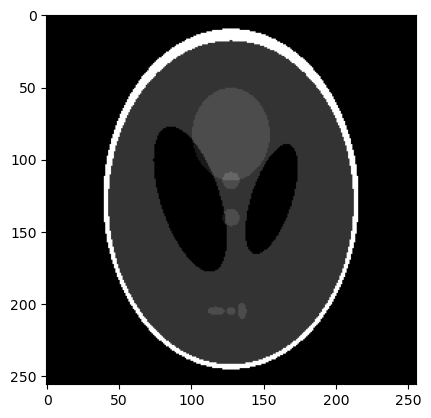

In [32]:
#可视化
pylab.gray()  # 使用灰度图显示
pylab.figure(1)
pylab.imshow(P) 

# <span style="font-size: 30px; color: blue;">4. 正投影模拟</span>
<span style="font-size: 20px; color: black;">接下来我们要计算这个几何条件下的正投影弦图。当扫描架以等角步进（Δθ=1°）旋转时，512个探测单元以1mm间距同步采集穿透仿体的衰减信号，最终形成180×512的投影矩阵</span>

In [33]:
sinogram_id, sinogram = astra.create_sino(P, proj_id)
# sinogram : 生成的180×512正弦图数据
sinogram.shape

(180, 384)

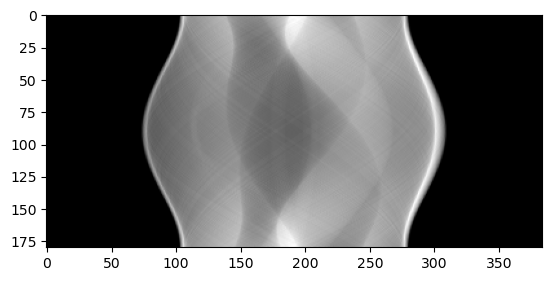

In [34]:
pylab.figure(2)
pylab.imshow(sinogram) # 显示CT扫描结果（像扇形展开的胶片）
pylab.show()

In [36]:
sinogram_id2, sinogram2 = astra.create_sino(P, proj_id2)
# sinogram : 生成的180×512正弦图数据
sinogram.shape

(180, 384)

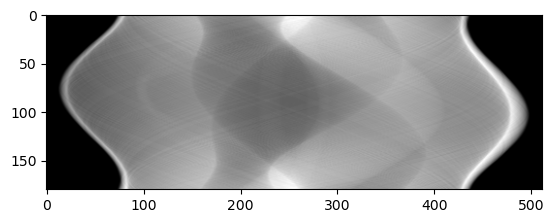

In [42]:
pylab.figure(2)
pylab.imshow(sinogram2) # 显示CT扫描结果（像扇形展开的胶片）
pylab.show()

# <span style="font-size: 30px; color: blue;">5. 清理内存</span>
<span style="font-size: 20px; color: black;">ASTRA会在GPU上分配内存，需要手动释放</span>

In [45]:
astra.data2d.clear()
astra.projector.clear()